# Revisiting Keane and Wolpin (1997)
**Parameter Estimation via the Method of Simulated Moments**

In their seminal paper on the career decisions of young men, Keane and Wolpin (1997) estimate a life-cycle model for occupational choice based on NLSY data for young white men. The paper contains a basic and an extended specification of the model. Both models allow for overall five choice alternatives in each period: white collar sector work, blue collar sector work, military work, school, and staying home. Choice options come with pecuniary and/or non-pecuniary rewards. Agents are assumed to be forward-looking and act under uncertainty because of the occurrence of  alternative-specific shocks that affect the current reward of alternatives and only become know to individuals in the period they occur in.  Individuals thus form expectations about future shocks and in each period choose the option that maximizes the expected present value of current and future lifetime rewards.

The extended model compared to the base specification expands the model by introducing more complex skill technology functions that for example allow for skill depreciation and age effects, job mobility and search costs, non-pecuniary rewards for work, re-entry costs for school, and some common returns for school.

`respy` is able to solve, simulate, and estimate both model specifications. Within `respy`, they are referred to as `kw_97_basic` and `kw_97_extended`. In this article, we will focus on the parameterization of the basic model presented in Keane and Wolpin (1997) which, as will be discussed below, returns relatively questionable life-cycle choice patterns, prompting further investigation. The model specification can be loaded using the function `get_example_model` as demonstrated below. The returned parameter vector contains the estimated parameters from the paper and the returned DataFrame contains the 'observed' NLSY data.

In [1]:
import numpy as np
import pandas as pd
import respy as rp
import matplotlib.pyplot as plt

In [2]:
params_basic_kw, options, data_obs = rp.get_example_model("kw_97_basic")

## Choice patterns and rewards for parameters in `kw_97_basic`

To investigate the parameter specification presented for the basic model in Keane and Wolpin (1997), we will look at the choice frequencies in each period and compare them to the observed data. While the NLSY data is only observed for the first 11 years, the models can be used to predict choices over the entire work life of agents. This is what's discussed as the out-of-sample fit in Keane and Wolpin (1997). The standard time horizon in `kw_97_basic` is 50 periods since Keane and Wolpin (1997) fix the terminal age to 65 with individuals entering the sample at age 15. We will thus inspect how well the model generated by the parameters can fit the observed data, as well as the predictions it makes for the rest of the life-cycle.

### Choice Patterns

As a first step, we will look at the choices of agents over time. To do this, we can simulate data based on the parameters from `kw_97_basic` and compute the choice frequencies in each period. We then plot them against the observed choices.

In [3]:
simulate = rp.get_simulate_func(params_basic_kw, options)
data_sim_kw = simulate(params_basic_kw)

Compute choice frequencies for observed and simulated data and plot them:

In [4]:
def calc_choice_frequencies(df):
    """Compute choice frequencies."""
    return df.groupby("Period").Choice.value_counts(normalize=True).unstack()

In [5]:
choices_obs = calc_choice_frequencies(data_obs)

In [6]:
choices_obs = calc_choice_frequencies(data_obs)
choices_kw = calc_choice_frequencies(data_sim_kw)

In [7]:
def plot_moments(moments_obs, moments_sim, labels, colors):
    """Plot moments.
    """
    plt.figure(figsize=(14, 4))
    for i, (label, color) in enumerate(zip(labels, colors)):
        plt.subplot(1, 5, i + 1)
        plt.tight_layout()
        plt.title(label.capitalize())
        plt.xlabel("Period")
        plt.plot(moments_sim[label], color=color)
        plt.plot(moments_obs[label], color="black", linestyle="dashed")
        plt.ylim(0, 1)
        plt.xlim(0, 50)

In [8]:
choices = ["blue_collar", "white_collar", "school", "home", "military"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

The plots below show the choice frequencies of individuals for the five different choice alternatives. The colored lines represent the simulated dataset while the black, dotted lines show the choices observed in the NLSY data. The simulated data does not seem to fit the observed data very well. The percentage of individuals choosing the white collar occupation is too high while all other choices are very underrepresented in the simulated data. 

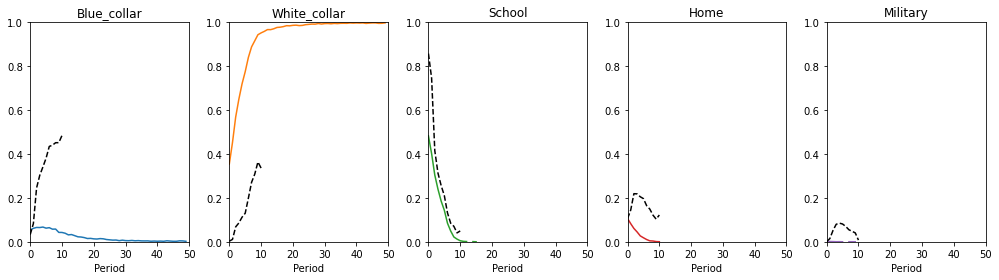

In [9]:
plot_moments(
    moments_obs=choices_obs, moments_sim=choices_kw, labels=choices, colors=colors,
)

###  Experience-Wage Profiles over the Life-Cycle 

As a next step, we will inspect the experience-wage profiles suggested by the model. The function below computes the wages of a skill **type 0** individual (skill endowment types are a source of heterogeneity between individuals in the model) with **10 years of schooling** for the given wage parameters if they enter an occupation in period 0 and stay in that occupation for their entire life-cycle.

In [10]:
def get_experience_profile(params, options, occupation):

    # To fix ideas we look at a Type 0 individual with 10 years of schooling
    # who immediately starts to work in the labor market.
    covars = [1, 10, 0, 0, 0, 0, 0, 0, 0]

    wages = list()
    for period in range(options["n_periods"]):
        if occupation == "blue_collar":
            covars[3] = period
            covars[4] = period ** 2 / 100
        elif occupation == "white_collar":
            covars[2] = period
            covars[3] = period ** 2 / 100
            
        wage = np.exp(np.dot(covars, params.loc[f"wage_{occupation}", "value"]))
        wages.append(wage)

    return wages

In [11]:
def plot_experience_profiles(params, options):

    colors = ["tab:blue", "tab:orange"]
    occupations = ["blue_collar", "white_collar"]

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    for i, (label, color) in enumerate(zip(occupations, colors)):
        wage_profile = get_experience_profile(params, options, label)
        ax[i].plot(range(options["n_periods"]), wage_profile, color=color)
        ax[i].set_xlabel("Experience in Periods")
        ax[i].set_ylabel("Wages")
        ax[i].set_title(label)
        plt.tight_layout()

We can then plot the wage-experience profiles of the three occupations. The wage profiles do not seem very realistic, as especially the white collar occupation sees unlimited wage growth into the millions which is not observable in practice for the average individual.The curve is missing the characteristic flattening (slowed and sometimes even negative wage growth) in later stages of life that is well documented in the life-cycle wage literature (Heckman et al., 2006).

The military option is purposely left out in this plot since the low number of observations in the NLSY data for this occupation does not allow for the construction of an appropriate experience-wage profile.

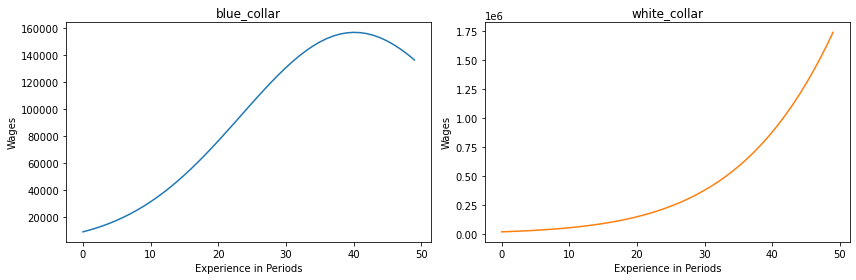

In [12]:
plot_experience_profiles(params_basic_kw, options)

Since this flattening characteristic is controlled by the exponential term in the wage equation, we can see if adjusting this parameter improves the wage profile for the white collar occupation. The parameter specification in the paper gives this parameter a value of -0.0461. We will choose a smaller value to attempt to flatten the curve in later periods.

In [13]:
params_new = params_basic_kw.copy()
params_new.loc[("wage_white_collar", "exp_white_collar_square"), "value"] = -0.15

As the plots below show, the new value for `(wage_white_collar, exp_white_collar_square)` produces a more realistic wage profile and wage for the white collar occupation:

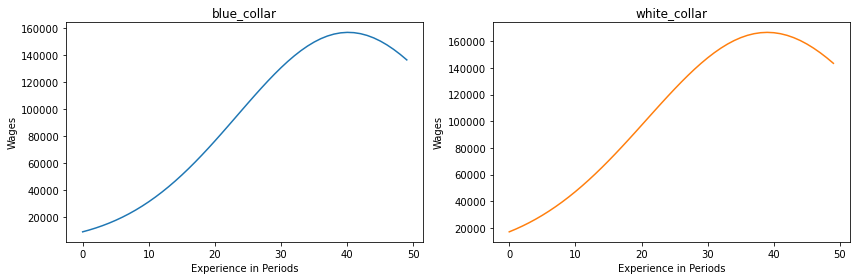

In [14]:
plot_experience_profiles(params_new, options)

From the investigation of choice patters and wage profiles above, we can derive the suspicion, that the parameters stated in the paper are flawed and can be improved on to achieve a better fit of the model.

## New Paramter Estimates: Method of Simulated Moments Estimation

In the next step, we thus attempt to estimate the parameters via the Method of Simulated Moments (MSM) to improve the fit. The following sections illustrate the MSM setup for estimation and show the results.

### MSM Estimation Setup 

The estimation setup for MSM follows the pattern already established in other articles of the documentation. Click below to learn more about the MSM interface in `respy`.

For the estimation we use moments that capture the choice frequencies for each period and mean wages as well as their standard deviation.The inputs are defined in dictionaries.

In [15]:
def calc_choice_freq(df):
    return df.groupby("Period").Choice.value_counts(normalize=True).unstack()


def calc_wage_distr(df):
    return df.groupby(["Period"])["Wage"].describe()[["mean", "std"]]


def fill_nans_zero(df):
    return df.fillna(0)


calc_moments = {
    "Choice Frequencies": calc_choice_freq,
    "Wage Distribution": calc_wage_distr,
}

empirical_moments = {
    "Choice Frequencies": fill_nans_zero(calc_choice_freq(data_obs)),
    "Wage Distribution": fill_nans_zero(calc_wage_distr(data_obs)),
}

The weighting matrix used is a diagonal inverse variance weighting matrix. Since it takes a while to compute, we saved it to a pickle file that we can load for subsequent uses in estimation without having to compute it again.

In [16]:
weighting_matrix = pd.read_pickle("weighting_matrix.pkl")

We can now construct the criterion function. Aside from the usual specification, we can also set the argument `n_simulation_periods` to 11 since there are only eleven periods in the observed data. This does not affect the number of periods that decision rules are computed for, just the number of periods that are simulated during estimation. Since the remaining periods will be dropped when matching simulated moments to empirical moments anyway, using this argument can save a bit of computation time during optimization (around 1-2 seconds per iteration for this specification).

In [17]:
msm_criterion = rp.get_msm_func(
    params=params_basic_kw,
    options=options,
    calc_moments=calc_moments,
    replace_nans=fill_nans_zero,
    empirical_moments=empirical_moments,
    weighting_matrix=weighting_matrix,
    n_simulation_periods=11,
)

We can now evaluate the criterion at the parameter specification from Keane and Wolpin (1997). The value is quite high, as can be expected from the poor fit of moments like the choice frequencies regarded in the plots above. To estimate a new set of parameters we will hand the criterion function and parameters to an optimizer. The optimization involves multiple further steps like setting bounds and constraints, which will not be discussed here but can be read up on in the article linked below.

In [18]:
msm_criterion(params_basic_kw)

355138.48791172705

### Estimation Results

The following section discusses our estimation results using the MSM setup discussed above. For the estimation we use [estimagic](https://estimagic.readthedocs.io/en/latest/) and the derivative-free optimizer [BOBYQA](https://estimagic.readthedocs.io/en/latest/optimization/algorithms.html). To assess the results, we will plot the choices and wage profiles again for the estimated parameter vector. The estimated parameter vector contains the suffix 'respy' The criterion function value has been reduced  significantly compared to its starting value which already suggests a notable improvement in the model fit.

In [19]:
params_basic_respy, _, _ = rp.get_example_model("kw_97_basic_respy")

In [20]:
msm_criterion(params_basic_respy)

1867.1731022234094

#### Choice Patterns 

We will first investigate the choice patterns of individuals over the 11 observed periods and the predicted choices in later periods. The plot below shows the choice frequencies for the observed data and simulated data for the specification in Keane and Wolpin (1997) and our estimates respectively in an area plot. The new estimates fit the observed data much better.

In [21]:
data_sim_new = simulate(params_basic_respy)

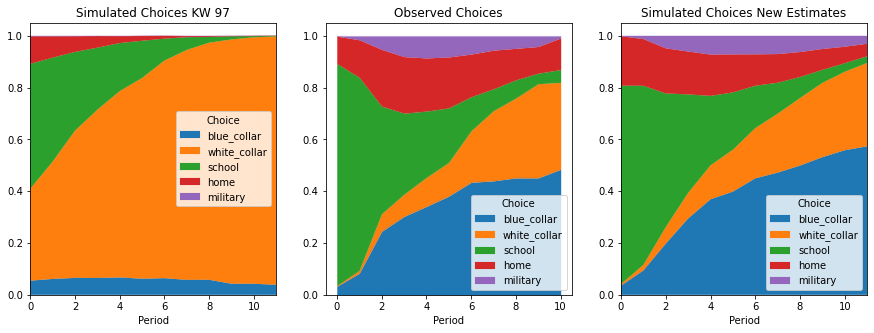

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
calc_choice_frequencies(data_sim_kw)[choices].plot(
    kind="area",
    stacked=True,
    ax=axes[0],
    xlim=[0,11],
    title="Simulated Choices KW 97",
    linewidth=0.1,
)
calc_choice_frequencies(data_obs)[choices].plot(
    kind="area", stacked=True, ax=axes[1], title="Observed Choices", linewidth=0.1
)
calc_choice_frequencies(data_sim_new)[choices].plot(
    kind="area",
    stacked=True,
    ax=axes[2],
    xlim=[0,11],
    title="Simulated Choices New Estimates",
    linewidth=0.1,
)

Plotting the choices separately against their observed counterpart also reveals a much better fit.

In [23]:
choices_new = calc_choice_frequencies(data_sim_new)

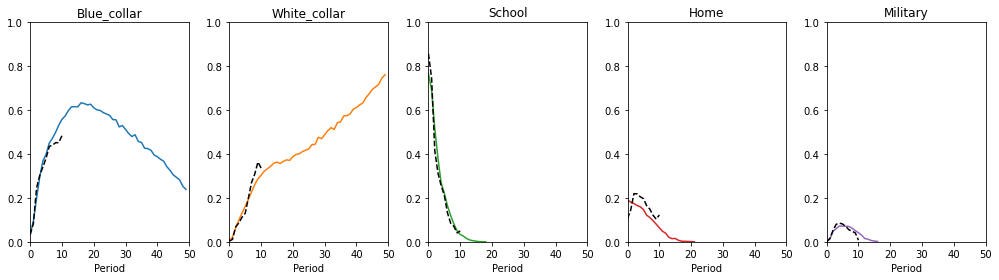

In [24]:
plot_moments(
    moments_obs=choices_obs, moments_sim=choices_new, labels=choices, colors=colors,
)

#### Experience-Wage Profiles

Looking at the wage profiles now, the fit has improved although the earned wages in later periods are still unreasonably high, especially for the blue collar occupation. This pattern of period rewards connects well to the estimated choice patterns for the first 11 periods. Given the relatively high wages in the blue collar occupation for this specification , it is not surprising that the choice frequencies in the simulated data are too low for the white collar sector and too high for the blue collar sector compared to the observed sample. 

These problems in wage gains are similar to the ones shown by Keane and Wolpin (1997) for the basic specification and give way to the expanded model, which promises a more reasonable development of life-cycle patterns.

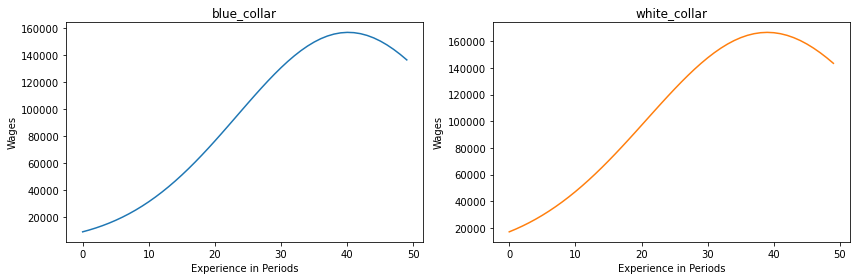

In [25]:
plot_experience_profiles(params_new, options)

## Estimates of the Extended Model

In addition to the basic Model parameters, we also re-estimate the extended model specified in Keane and Wolpin (1997). Since the parameter space for this model is much larger than the basic specification, we expand the number of moments used for estimation. The new sets of moments used are conditional on the period and initial level of schooling of individuals. Specifically, we compute the choice frequencies and wage statistics for two initial schooling groups: those with up to 9 years of schooling at age 16 and those with 10 years or more. Furthermore, the moments for the wage distribution are expanded to include the median and 25% as well as 75% percentile for each initial schooling group in each period.  

In [26]:
data_extended_kw = pd.read_pickle("data/simulated_data_kw_97_extended.pkl")
data_extended_respy = pd.read_pickle("data/simulated_data_kw_97_extended_respy.pkl")

In [27]:
choices_obs = calc_choice_frequencies(data_obs)

#### Choice Frequencies for extended parameterization from Keane and Wolpin (1997)

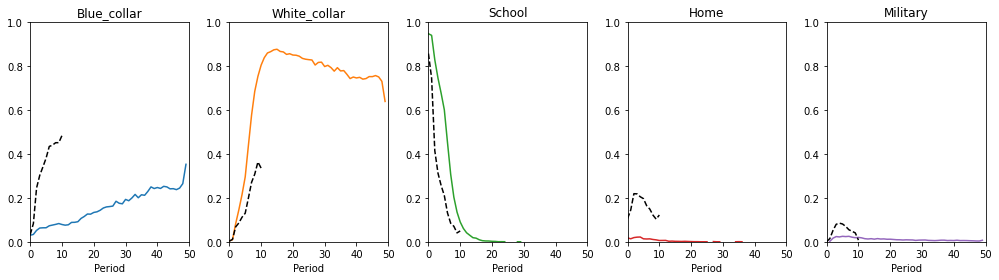

In [28]:
choices_extended_kw = calc_choice_frequencies(data_extended_kw)
plot_moments(
    moments_obs=choices_obs, moments_sim=choices_extended_kw, labels=choices, colors=colors,
)

#### Choice Frequencies Estimated Parameters

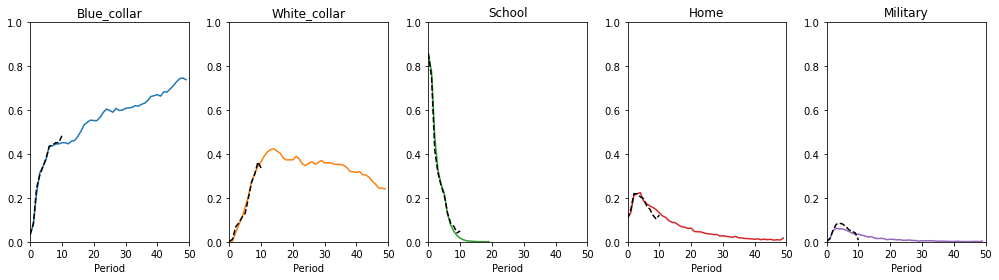

In [29]:
choices_extended_respy = calc_choice_frequencies(data_extended_respy)
plot_moments(
    moments_obs=choices_obs, moments_sim=choices_extended_respy, labels=choices, colors=colors,
)


### Unobserved Skill Heterogeneity

In [30]:
def construct_table_11(data, t):
    data = data.copy()
    # Add initial schooling for grouping
    initial_school = data.groupby("Identifier")["Experience_School"].min()
    initial_school.name = "Initial_Schooling"
    
    data.loc[(slice(None),t),"Initial_Schooling"] = initial_school.values
    data = data.loc[(slice(None),t),]
    data_low = data[data["Initial_Schooling"] < 10]
    data_high= data[data["Initial_Schooling"] >= 10]
    
    tables = []
    for df in data_low, data_high:
        exp = df.groupby("Type")[df.columns[df.columns.str.contains("Experience")]].mean().T
        choices = df.groupby("Type").Choice.value_counts(normalize=True).unstack().T
        tables.append(pd.concat([exp,choices],axis=0, keys=["Experience", "Choices"]))
        
    return pd.concat(tables, keys=["Less Than 10 Years School","At Least 10 Years School"], axis=1).round(2)

In [31]:
table_11 = construct_table_11(data_extended_respy, 8)
table_11

Less Than 10 Years School                \
Type                                                       0      1      2   
           Choice                                                            
Experience Experience_Blue_Collar                       0.53   2.71   2.64   
           Experience_Military                          0.00   0.00   0.78   
           Experience_White_Collar                      0.84   0.95   0.86   
           Experience_School                           13.32  11.74  10.85   
Choices    blue_collar                                  0.08   0.47   0.50   
           home                                         0.24   0.14   0.14   
           military                                      NaN    NaN   0.09   
           school                                       0.26   0.06   0.01   
           white_collar                                 0.42   0.33   0.26   

                                          At Least 10 Years School         \
Type                                    3                        0      1   
           Choice                                                           
Experience Experience_Blue_Collar    1.22                     0.53   2.49   
           Experience_Military       0.01                     0.00   0.00   
           Experience_White_Collar   0.16                     1.16   0.66   
           Experience_School        10.41                    15.59  14.36   
Choices    blue_collar               0.31                     0.12   0.55   
           home                      0.63                     0.10   0.03   
           military                  0.00                      NaN    NaN   
           school                    0.01                     0.12   0.10   
           white_collar              0.04                     0.66   0.32   

                                                  
Type                                    2      3  
           Choice                                 
Experience Experience_Blue_Collar    2.59   1.43  
           Experience_Military       0.43   0.02  
           Experience_White_Collar   1.02   0.21  
           Experience_School        13.06  13.22  
Choices    blue_collar               0.50   0.39  
           home                      0.11   0.43  
           military                  0.05   0.01  
           school                    0.03   0.06  
           white_collar              0.31   0.11

In [32]:
def construct_table_12(data, t1, t2):
    
    # Add initial schooling for grouping
    data = data.loc[(slice(None),[t1,t2]),].copy()
    initial_school = data.groupby("Identifier")["Experience_School"].min()
    initial_school.name = "Initial_Schooling"
    data = data.join(initial_school, on="Identifier")
    columns = list(data.columns[data.columns.str.contains("Value_Function|Type|Initial_Schooling")])
    low = data[data["Initial_Schooling"] < 10][columns]
    high = data[data["Initial_Schooling"] >= 10][columns]
    
    tables = []
    for df in high,low:
        df.drop("Initial_Schooling",axis=1, inplace=True)
        
        # Compute max over choices
        df.loc[(slice(None),[t1,t2]),"Maximum Over Choices"] = df.loc[(slice(None),[t1,t2]),].max(axis=1)
        table_all = df.groupby(["Period"]).mean().unstack().T.round(1).drop("Type")
        table_all.name = "all"
        table_types = df.groupby(["Type","Period"]).mean().unstack().T
        table = pd.concat([table_all, table_types], axis=1)
        tables.append(table)
        
    return pd.concat(tables, keys=["At Least 10 Years School", "Less Than 10 Years School"]).round(3)


In [33]:
table_12 = construct_table_12(data_extended_respy, 0, 10)

In [34]:
table_12.loc["At Least 10 Years School"].astype(int).style.highlight_max()

In [35]:
table_12.loc["Less Than 10 Years School"].astype(int).style.highlight_max()

### Effect of a College Tuition Subsidy

Finally, we inspect the policy implications of the model parameters. One of the defining advantages of structural econometric models is their ability to construct counterfactuals suited for ex-ante policy analysis. Keane and Wolpin (1997) apply their model to the evaluation of a college tuition subsidy of $2000. We want to evaluate the subsidy for our new paramaters and adjust the parameter `("nonpec_school", "hs_graduate")` accordingly to simulate data.

#### Extended Model (40 Periods)

In [36]:
data_extended_respy_subsidy = pd.read_pickle("data/simulated_data_kw_97_extended_respy_tuition_subsidy.pkl")

To evaluate the tuition subsidy, Keane and Wolpin (1997) inspect its effect on school attainment of the different types. Specifically, this includes the graduation rates for high school and college (i.e. the percentage of individuals that acquire at least 12 or 16 years of schooling) as well as the mean years of schooling and mean years of post-secondary education.

In [37]:
def add_schooling_columns(df):
    """ 
    Add dummy columns for high school and college degrees and compute years of 
    experience in college. 
    """
    df["HS_Degree"] = np.where(df["Experience_School"] >= 12, 1, 0)
    df["Co_Degree"] = np.where(df["Experience_School"] >= 16, 1, 0)
    df["Experience_College"] = np.where(
    df["Experience_School"] >= 12, df["Experience_School"] - 12, 0)
    return df

In [38]:
def compute_subsidy_effect(df_subsidy, df_no_subsidy):
    schooling_dict = {}
    for label in ["HS_Degree", "Co_Degree", "Experience_School", "Experience_College"]:
        type_means = {}
        for df, name in zip([df_subsidy, df_no_subsidy], ["Subsidy", "No Subsidy"]):
            df = df.copy()
            df = df.loc[(slice(None), df.index.get_level_values("Period").max()), ]
            type_df = df.groupby("Type")[label].mean()
            type_df["all"] = df[label].mean()
            type_means[name] = type_df
        schooling_dict[label] = type_means
        schooling = pd.concat({k: pd.DataFrame(v).T for k,v in schooling_dict.items()}, axis=0).unstack().T
    return schooling

In [39]:
data_extended_respy_subsidy = add_schooling_columns(data_extended_respy_subsidy)
data_extended_respy = add_schooling_columns(data_extended_respy)
subsidy = compute_subsidy_effect(data_extended_respy_subsidy, data_extended_respy)

In [40]:
def plot_subsidy(data):
    fig, ax = plt.subplots(2, 2, figsize=(15, 11))
    ax = ax.ravel()
    ylabels = ["% Graduated", "% Graduated", "Mean Schooling Years", "Mean Schooling Years"]
    for i, (column, ylabel) in enumerate(zip(data.columns, ylabels)):
        ax[i].set_ylabel(ylabel)
        data[column].unstack().plot(kind="bar", title=column,
                                      ax=ax[i], rot=0, legend=False)
        fig.legend(["Subsidy", "No Subsidy"], loc="lower center",ncol=2)

The plot below shows the schooling attainment of 5000 simulated agents with and without the subsidy. The plots in the upper row show the percentage of high school and college graduates by type and the plots in the lower row show the average school years and college years by type in the sample. Similar to Keane and Wolpin (1997), the results show fairly high heterogeneities between types. 

In [41]:
subsidy.unstack().round(2)

HS_Degree            Co_Degree            Experience_School             \
       Subsidy No Subsidy   Subsidy No Subsidy           Subsidy No Subsidy   
Type                                                                          
0         0.99       0.98      0.93       0.87             15.96      15.69   
1         0.91       0.88      0.65       0.45             14.61      13.85   
2         0.83       0.79      0.37       0.20             13.32      12.60   
3         0.64       0.58      0.36       0.22             12.65      11.99   
all       0.83       0.80      0.46       0.30             13.66      12.99   

     Experience_College             
                Subsidy No Subsidy  
Type                                
0                  4.01       3.76  
1                  2.84       2.14  
2                  1.73       1.07  
3                  1.64       1.08  
all                2.08       1.47

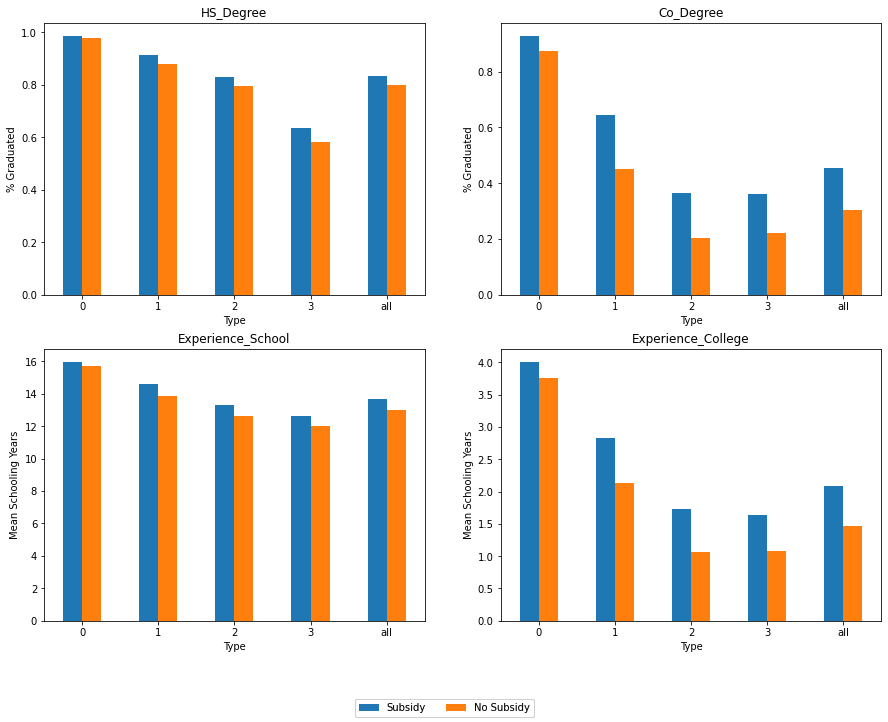

In [42]:
plot_subsidy(subsidy)

# References

- Heckman, J. J., Lochner, L. J., & Todd, P. E. (2006). [Earnings functions, rates of return and treatment effects: The Mincer equation and beyond](https://www.sciencedirect.com/science/article/pii/S1574069206010075). In Hanushek, E. & Welch, F., editors, *Handbook of the Economics of Education*, volume 1, pages 307–458. Elsevier Science, Amsterdam, Netherlands.

- Keane, M. P. and Wolpin, K. I. (1997). [The Career Decisions of Young Men](https://www.jstor.org/stable/10.1086/262080?seq=1). *Journal of Political Economy*, 105(3): 473-522.